In [2]:
# import libray
import numpy as np 
import pandas as pd 
from sklearn.feature_extraction import _stop_words
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense,Embedding,Conv1D,MaxPooling1D,LSTM

In [3]:
# read data from csv file
df = pd.read_csv('/kaggle/input/dataset6/TrainingSet_2_Class.csv')
df.head()

,label,text
0,1,Disabled Vehicle on Westbound highway WB at Em...
1,0,New Teacher Lunch &amp; training! Marker wars ...
2,0,And the spot in our #uhaultrends Canadian Des...
3,0,"years ago today #MLK gave his historic ""I Hav..."
4,0,Aww it’s always hard to say goodbye! 😢 What’s...


In [4]:
# text length
df['text_length'] = df['text'].apply(len)
df[['label','text']].head()

,label,text
0,1,Disabled Vehicle on Westbound highway WB at Em...
1,0,New Teacher Lunch &amp; training! Marker wars ...
2,0,And the spot in our #uhaultrends Canadian Des...
3,0,"years ago today #MLK gave his historic ""I Hav..."
4,0,Aww it’s always hard to say goodbye! 😢 What’s...


In [ ]:
# count the number of label
data["label"].value_counts()

In [7]:
# data preprocessing using spacy
import spacy
import string

nlp = spacy.load('en_core_web_lg')

stopwords = _stop_words.ENGLISH_STOP_WORDS
lemmatizer = WordNetLemmatizer()

# data cleaning function
def clean(doc):
    text_no_namedentities = []
    document = nlp(doc)
    ents = [e.text for e in document.ents]
    for item in document:
        if item.text in ents:
            pass
        else:
            text_no_namedentities.append(item.text)
            
    doc = (" ".join(text_no_namedentities))
    doc = doc.lower().strip()
    doc = doc.replace("</br>", " ") 
    doc = doc.replace("-", " ") 
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    doc = " ".join([token for token in doc.split() if token not in stopwords])    
    doc = "".join([lemmatizer.lemmatize(word) for word in doc])
    
    return doc

In [9]:
# cleaning the tweet data
data['text'] = data['text'].apply(clean)
data.head()

,label,text,text_length,clean_tweet
0,1,Disabled Vehicle on Westbound highway WB at Em...,103,disabled vehicle westbound highway wb emily dr...
1,0,New Teacher Lunch &amp; training! Marker wars ...,104,new teacher lunch amp training marker wars w s...
2,0,And the spot in our #uhaultrends Canadian Des...,95,spot uhaultrends destination cites countdown t...
3,0,"years ago today #MLK gave his historic ""I Hav...",84,years ago gave historic dream speech marchonwa...
4,0,Aww it’s always hard to say goodbye! 😢 What’s...,88,aww ’s hard say goodbye 😢 ’s favorite memory


In [10]:
# load the data in x and y variable
X = df['text']
y = pd.get_dummies(df['label']).values

# number of labels 
num_classes = df['label'].nunique()

In [11]:
seed = 101
np.random.seed(seed)

In [12]:
# spliting the data in trainig set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(40880,) (10220,) (40880, 2) (10220, 2)


In [13]:
# Tokenize Text data
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

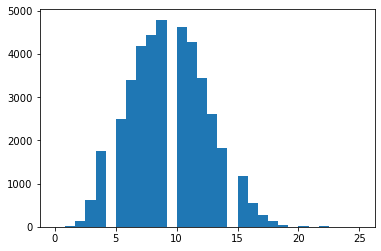

In [14]:
# total number of words in text
totalNumWords = [len(one_comment) for one_comment in X_train]

In [15]:
# padding the train data
max_words = 150
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
print(X_train.shape,X_test.shape)

(40880, 150) (10220, 150)


In [17]:
# cnn parameters
batch_size = 128
epochs = 20

In [18]:
# cnn and lstm model create and compile
def get_model(max_features, embed_dim):
    np.random.seed(seed)
    K.clear_session()
    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))    
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

In [19]:
# loading the train data and training the model
def model_train(model):
    model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                          epochs=epochs, batch_size=batch_size, verbose=2)

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

# evaluating the accuracy and loss of the model
def model_evaluate(): 
    cnn_loss, cnn_accuracy = model.evaluate(X_test, y_test)
    y_pred_cnn = model.predict(X_test)
    y_pred_cnn = (y_pred_cnn > 0.5).astype(int)

    print(f"CNN Accuracy: {cnn_accuracy}")
    print(f"CNN Loss: {cnn_loss}")
    print(f"CNN MSE: {cnn_mse}")
    
    # classification report of the model on test dataset
    classification_rep = classification_report(y_test, y_pred_cnn)
    print(classification_rep)

In [21]:
# train the model
max_features = 20000
embed_dim = 100
model = get_model(max_features, embed_dim)
model_train(model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 100)          2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 150, 32)           9632      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 75, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 75, 32)            3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 37, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (None, 2)                 2

In [22]:
# evaluate model with test set
model_evaluate()

320/320 [==============================] - 3s 10ms/step - loss: 0.1196 - accuracy: 0.9822
CNN Accuracy: 0.982191801071167
CNN Loss: 0.11955401301383972
CNN MSE: 0.01780821917808219
